In [ ]:
from numpy import loadtxt
import numpy as np
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import joblib
import time
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
#installing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    # Ensure that the seed is set for CUDA convolution operations to ensure reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [ ]:
#positions = np.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt') #load datasets
winners = pd.read_csv("/content/drive/MyDrive/My_stratego_project/files/Y_winners_encoded.csv", header = None)
positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt')
positions = np.array(positions).reshape((99130, 40, 12)) #Reshaping the data to a 40 by 12 matrix

In [ ]:
"""Changes the one hot encoding to a row hot encoding"""
#positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions (1).txt') #comment out if you want to use the one-hot encoding instead


'Changes the one hot encoding to a row hot encoding'

In [ ]:
"""Changes the one hot encoding to a row hot encoding and normalized"""
#positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions_normalized.txt') #comment out if you want to use the one-hot encoding instead


'Changes the one hot encoding to a row hot encoding and normalized'

In [ ]:
positions.shape, len(winners)

((99130, 40, 12), 99130)

In [ ]:
"""for -1 to 1 classification, changes winner variable to -1 and 1, comment out to use 0/1 classification"""
winners_new = []
i=0
for winner in winners[0]:
  if winner == 0:
    winners_new.append(winner)
  else:
    winners_new.append(winner)
  i+=1

In [ ]:
"""Creates 4 edge indeces based on the sizes created after the sagpooling operation, they're all square boards"""

##Possible imporvement to be added is to create edge index based on removed and included nodes after the sagpooling operation
def edge_index(row,column):
  """Creates a edge index based on a number of rows and columns as input"""
  edge_index = []
  for row in range(num_rows):
      for col in range(num_cols):
          node_idx = row * num_cols + col

          if row > 0:  #connect to top neighbor
              top_neighbor_idx = (row - 1) * num_cols + col
              edge_index.append([node_idx, top_neighbor_idx])

          if row < num_rows - 1:  #connect to bottom neighbor
              bottom_neighbor_idx = (row + 1) * num_cols + col
              edge_index.append([node_idx, bottom_neighbor_idx])

          if col > 0:  #connect to left neighbor
              left_neighbor_idx = row * num_cols + (col - 1)
              edge_index.append([node_idx, left_neighbor_idx])

          if col < num_cols - 1:  #connect to right neighbor
              right_neighbor_idx = row * num_cols + (col + 1)
              edge_index.append([node_idx, right_neighbor_idx])

  return torch.tensor(edge_index).t().contiguous()

num_rows = 4
num_cols = 10
edge_index1 = edge_index(num_rows , num_cols)#(4,10)
edge_index1 = np.array(edge_index1)

In [ ]:
edge_index1[1]

array([10,  1, 11,  0,  2, 12,  1,  3, 13,  2,  4, 14,  3,  5, 15,  4,  6,
       16,  5,  7, 17,  6,  8, 18,  7,  9, 19,  8,  0, 20, 11,  1, 21, 10,
       12,  2, 22, 11, 13,  3, 23, 12, 14,  4, 24, 13, 15,  5, 25, 14, 16,
        6, 26, 15, 17,  7, 27, 16, 18,  8, 28, 17, 19,  9, 29, 18, 10, 30,
       21, 11, 31, 20, 22, 12, 32, 21, 23, 13, 33, 22, 24, 14, 34, 23, 25,
       15, 35, 24, 26, 16, 36, 25, 27, 17, 37, 26, 28, 18, 38, 27, 29, 19,
       39, 28, 20, 31, 21, 30, 32, 22, 31, 33, 23, 32, 34, 24, 33, 35, 25,
       34, 36, 26, 35, 37, 27, 36, 38, 28, 37, 39, 29, 38])

Strategy 1; Surround flag by bombs

In [ ]:
positions[0]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [ ]:
positions[0][:,11]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [ ]:
import numpy as np


# Loop through the positions dataset
def calculate_bomb_flag_ratios(positions, edge_index1):
    b_f_ratio_list = []
    # Loop through the positions dataset
    if len(positions) == 40:
        # Get flag and bomb positions
        flag_pos = np.where(position[:,11] != 0)[0]
        bomb_positions = np.where(position[:, 0] != 0)[0]

        # Get outgoing edges from bombs
        index_list_bomb = [index for index, val in enumerate(edge_index1[0]) if val in bomb_positions]
        outedge_bomb = edge_index1[1, index_list_bomb]

        # Get outgoing edges from flag
        index_list_flag = [index for index, val in enumerate(edge_index1[0]) if val in flag_pos]
        outedge_flag = edge_index1[1, index_list_flag]

        bomb_count_adj_flag = np.count_nonzero(outedge_bomb == flag_pos)
        # Calculate ratio
        if bomb_count_adj_flag != 0:
            ratio = bomb_count_adj_flag / len(outedge_flag)
        else:
            ratio = 0
        # Create list for ratios of flag outgoing edges covered by bombs
        b_f_ratio_list.append(ratio)

        return b_f_ratio_list

    else:
        for position in positions:
            # Get flag and bomb positions
            flag_pos = np.where(position[:, 11] != 0)[0]
            bomb_positions = np.where(position[:, 0] != 0)[0]

            # Get outgoing edges from bombs
            index_list_bomb = [index for index, val in enumerate(edge_index1[0]) if val in bomb_positions]
            outedge_bomb = edge_index1[1, index_list_bomb]

            # Get outgoing edges from flag
            index_list_flag = [index for index, val in enumerate(edge_index1[0]) if val in flag_pos]
            outedge_flag = edge_index1[1, index_list_flag]

            bomb_count_adj_flag = np.count_nonzero(outedge_bomb == flag_pos)
            # Calculate ratio
            if bomb_count_adj_flag != 0:
                ratio = bomb_count_adj_flag / len(outedge_flag)
            else:
                ratio = 0
            # Create list for ratios of flag outgoing edges covered by bombs
            b_f_ratio_list.append(ratio)

        return b_f_ratio_list

b_f_ratio_list = calculate_bomb_flag_ratios(positions, edge_index1)
len(b_f_ratio_list)

99130

In [ ]:
b_f_ratio_list[0]

1.0

Strategy 2; 10 and 9 distance to each other

In [ ]:
def calculate_marshal_general_distances(positions):
    distance_10_to_9_list = []
    # Loop through the positions dataset
    if len(positions) == 40:
      # Get marshal and general positions
        marshal_pos = np.where(position[:, 10] != 0)[0]
        general_pos = np.where(position[:, 9] != 0)[0]

        # Calculate the row and column indices for each position
        row1 = general_pos // 10
        col1 = general_pos - (row1 * 10)
        row2 = marshal_pos // 10
        col2 = marshal_pos - (row2 * 10)

        # Calculate the absolute difference in row and column positions
        row_diff = abs(row2 - row1)
        col_diff = abs(col2 - col1)

        # Calculate the number of spaces between the two pieces
        if row_diff.size > 0 and col_diff.size > 0:  # Ensure that both arrays are not empty
            num_spaces = int((row_diff + col_diff)[0])
        else:
            num_spaces = 0  # Default value if positions are not found

        distance_10_to_9_list.append(num_spaces)

        return distance_10_to_9_list
    for position in positions:
        # Get marshal and general positions
        marshal_pos = np.where(position[:, 10] != 0)[0]
        general_pos = np.where(position[:, 9] != 0)[0]

        # Calculate the row and column indices for each position
        row1 = general_pos // 10
        col1 = general_pos - (row1 * 10)
        row2 = marshal_pos // 10
        col2 = marshal_pos - (row2 * 10)

        # Calculate the absolute difference in row and column positions
        row_diff = abs(row2 - row1)
        col_diff = abs(col2 - col1)

        # Calculate the number of spaces between the two pieces
        if row_diff.size > 0 and col_diff.size > 0:  # Ensure that both arrays are not empty
            num_spaces = int((row_diff + col_diff)[0])
        else:
            num_spaces = 0  # Default value if positions are not found

        distance_10_to_9_list.append(num_spaces)

    return distance_10_to_9_list

distance_10_to_9_list = calculate_marshal_general_distances(positions)
len(distance_10_to_9_list)

99130

Strategy 3; Distance of spy to general

In [ ]:
def calculate_spy_general_distances(positions):
    distance_spy_to_9_list = []
    # Loop through the positions dataset
    if len(positions) == 40:
        # Get spy and general positions
        spy_pos = np.where(positions[:, 1] != 0)[0]
        general_pos = np.where(positions[:, 9] != 0)[0]

        # Calculate the row and column indices for each position
        row1 = general_pos // 10
        col1 = general_pos - (row1 * 10)
        row2 = spy_pos // 10
        col2 = spy_pos - (row2 * 10)

        # Calculate the absolute difference in row and column positions
        row_diff = abs(row2 - row1)
        col_diff = abs(col2 - col1)

        # Calculate the number of spaces between the two pieces
        if row_diff.size > 0 and col_diff.size > 0:  # Ensure that both arrays are not empty
            num_spaces = int((row_diff + col_diff)[0])
        else:
            num_spaces = 0  # Default value if positions are not found

        distance_spy_to_9_list.append(num_spaces)

        return distance_spy_to_9_list
    else:
        for position in positions:
            # Get spy and general positions
            spy_pos = np.where(position[:, 1] != 0)[0]
            general_pos = np.where(position[:, 9] != 0)[0]

            # Calculate the row and column indices for each position
            row1 = general_pos // 10
            col1 = general_pos - (row1 * 10)
            row2 = spy_pos // 10
            col2 = spy_pos - (row2 * 10)

            # Calculate the absolute difference in row and column positions
            row_diff = abs(row2 - row1)
            col_diff = abs(col2 - col1)

            # Calculate the number of spaces between the two pieces
            if row_diff.size > 0 and col_diff.size > 0:  # Ensure that both arrays are not empty
                num_spaces = int((row_diff + col_diff)[0])
            else:
                num_spaces = 0  # Default value if positions are not found

            distance_spy_to_9_list.append(num_spaces)

        return distance_spy_to_9_list

distance_spy_to_9_list = calculate_spy_general_distances(positions)
len(distance_spy_to_9_list)


99130

Strategy 4; number of bombs on front row

In [ ]:
def calculate_bombs_first_row(positions):
    num_bomb_first_row_list = []
    # Loop through the positions dataset
    if len(positions)== 40:
        bomb_pos = np.where(positions[:, 0] != 0)[0]

        # Calculate the number of bombs in the first row
        num_bombs_first_row = np.count_nonzero(bomb_pos // 10 == 3)

        num_bomb_first_row_list.append(num_bombs_first_row)
    else:

        for position in positions:
            bomb_pos = np.where(position[:, 0] != 0)[0]

            # Calculate the number of bombs in the first row
            num_bombs_first_row = np.count_nonzero(bomb_pos // 10 == 3)

            num_bomb_first_row_list.append(num_bombs_first_row)

        return num_bomb_first_row_list
num_bomb_first_row_list = calculate_bombs_first_row(positions)
len(num_bomb_first_row_list)

99130

In [ ]:
num_bomb_first_row_list[0]

0

Strategy 5; Number of miners on the last row

In [ ]:
def calculate_miners_last_row(positions):
    num_miners_last_row_list = []

    if len(positions) == 40:
      miner_pos = np.where(positions[:, 3] != 0)[0]

      # Calculate the number of miners in the last row
      num_miners_last_row = np.count_nonzero(miner_pos // 10 == 0)

      num_miners_last_row_list.append(num_miners_last_row)

      return num_miners_last_row_list
    # Loop through the positions dataset
    else:
      for position in positions:
          miner_pos = np.where(position[:, 3] != 0)[0]

          # Calculate the number of miners in the last row
          num_miners_last_row = np.count_nonzero(miner_pos // 10 == 0)

          num_miners_last_row_list.append(num_miners_last_row)

      return num_miners_last_row_list

num_miners_last_row_list = calculate_miners_last_row(positions)
len(num_miners_last_row_list)

99130

Strategy 6; Scouts both in front and back rows

In [ ]:
def calculate_average_row_scouts(positions):
    average_row_scouts_list = []
    if len(positions) == 40:
      scouts_pos = np.where(position[:, 2] != 0)[0]
      if len(scouts_pos) > 0:
          scouts_on_rows = scouts_pos // 10
          average_row_scouts = np.mean(scouts_on_rows)
      else:
          average_row_scouts = 0  # Default value if no scouts are found

      average_row_scouts_list.append(average_row_scouts)

      return average_row_scouts_list

    # Loop through the positions dataset
    else:
      for position in positions:
          scouts_pos = np.where(position[:, 2] != 0)[0]

          if len(scouts_pos) > 0:
              scouts_on_rows = scouts_pos // 10
              average_row_scouts = np.mean(scouts_on_rows)
          else:
              average_row_scouts = 0  # Default value if no scouts are found

          average_row_scouts_list.append(average_row_scouts)

      return average_row_scouts_list


average_row_scouts_list = calculate_average_row_scouts(positions)
len(average_row_scouts_list)

99130

In [ ]:
np.mean(average_row_scouts_list)

1.5413850499344295

Strategy 7; Average Rank corridors(excluding bombs and flags)

In [ ]:
import numpy as np
corridor_strength_list_dataset = []
corridor_list = [[0,1,2],[3,4,5,6],[7,8,9]]#represents the corridors thus blocks of units close to each other potentiall relevant to the game
# Loop through the positions dataset
for position in positions:
  corridor_strength_list_match = []
  for corridor in corridor_list:
      mask = np.arange(position.reshape(4,10,12)[:,corridor].shape[2]) >= 1
      mask &= np.arange(position.reshape(4,10,12)[:,corridor].shape[2]) < 10  #creates mask such that flags and bombs are excluded

      # Apply the mask and get the column numbers for each row
      column_numbers = np.where(position.reshape(4,10,12)[:,corridor] * mask, np.arange(position.reshape(4,10,12)[:,corridor].shape[2]) + 1, 0)

      corridor_strength = np.sum(column_numbers)/(column_numbers.shape[0]*column_numbers.shape[1])
      corridor_strength_list_match.append(corridor_strength)
  corridor_strength_list_dataset.append(corridor_strength_list_match)
len(corridor_strength_list_dataset)

99130

In [ ]:
corridor_strength_list_dataset[0]

[4.416666666666667, 3.875, 4.583333333333333]

Adding the data to the dataset

In [ ]:
def calculate_all_effects(positions, edge_index1):
    all_effects = []

    # Check if positions is a single position
    if positions.ndim == 2:
        positions = [positions]  # Wrap single position into a list

    # Calculate bomb-to-flag ratios
    b_f_ratio_list = calculate_bomb_flag_ratios(positions, edge_index1)
    all_effects.append(b_f_ratio_list)

    # Calculate distances between marshal and general
    marshal_general_distances = calculate_marshal_general_distances(positions)
    all_effects.append(marshal_general_distances)

    # Calculate distances between spy and general
    spy_general_distances = calculate_spy_general_distances(positions)
    all_effects.append(spy_general_distances)

    # Calculate number of bombs in the first row
    num_bomb_first_row_list = calculate_bombs_first_row(positions)
    all_effects.append(num_bomb_first_row_list)

    # Calculate number of miners in the last row
    num_miners_last_row_list = calculate_miners_last_row(positions)
    all_effects.append(num_miners_last_row_list)


    return all_effects

In [ ]:
var_list = []
var_list.append(b_f_ratio_list)
var_list.append(distance_10_to_9_list)
var_list.append(distance_spy_to_9_list)
var_list.append(num_bomb_first_row_list)
var_list.append(num_miners_last_row_list)
var_list.append(average_row_scouts_list)
# Extract the three lists from corridor_strength_list_dataset
left_corridor_list = [item[0] for item in corridor_strength_list_dataset]
middle_corridor_list = [item[1] for item in corridor_strength_list_dataset]
right_corridor_list = [item[2] for item in corridor_strength_list_dataset]

# Append the extracted lists to var_list
var_list.append(left_corridor_list)
var_list.append(middle_corridor_list)
var_list.append(right_corridor_list)
var_list.append(winners_new)

# Ensure all lists have the same length
list_lengths = [len(lst) for lst in var_list]
print(list_lengths)
assert all(length == list_lengths[0] for length in list_lengths), "All lists must have the same length"

# Transpose the var_list to create a list of rows
data = list(zip(*var_list))

# Create the DataFrame with specified column names
column_names = {
    'feature_0': 'Ratio of bombs next to flag',
    'feature_1': 'Distance of marshal to general',
    'feature_2': 'Distance of spy to general',
    'feature_3': 'Number of bombs on front row',
    'feature_4': 'Number of miners on last row',
    'feature_5': 'Average row of Scouts',
    'feature_6': 'Left-side average corridor rank',
    'feature_7': 'Middle-side average corridor rank',
    'feature_8': 'Right-side average corridor rank',
    'feature_9': 'Target'
}

# Create DataFrame
df = pd.DataFrame(data, columns=column_names.keys())

# Rename columns
df.rename(columns=column_names, inplace=True)

# Print the DataFrame to verify

#remove the 1 file with a target with a 5
df = df[df['Target']!=5]

df.describe()

[99130, 99130, 99130, 99130, 99130, 99130, 99130, 99130, 99130, 99130]


,Ratio of bombs next to flag,Distance of marshal to general,Distance of spy to general,Number of bombs on front row,Number of miners on last row,Average row of Scouts,Left-side average corridor rank,Middle-side average corridor rank,Right-side average corridor rank,Target
count,99130.000000,99130.000000,99130.000000,99130.000000,99130.000000,99130.000000,99130.000000,99130.000000,99130.000000,99130.000000
mean,0.590502,3.958791,2.431686,1.405155,1.572672,1.541385,4.238017,4.272167,4.232427,0.500000
std,0.412987,1.823864,1.844202,1.378147,1.356442,0.555162,0.637285,0.532820,0.642933,0.500003
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.937500,1.250000,0.000000
25%,0.250000,3.000000,1.000000,0.000000,0.000000,1.125000,3.833333,3.875000,3.833333,0.000000
50%,0.666667,4.000000,2.000000,1.000000,1.000000,1.625000,4.250000,4.250000,4.250000,0.500000
75%,1.000000,5.000000,3.000000,2.000000,3.000000,2.000000,4.666667,4.625000,4.666667,1.000000
max,1.000000,12.000000,12.000000,6.000000,5.000000,3.000000,7.333333,6.812500,6.916667,1.000000


Data Analysis of strategies and their effect on winning a match

In [ ]:
df

,Ratio of bombs next to flag,Distance of marshal to general,Distance of spy to general,Number of bombs on front row,Number of miners on last row,Average row of Scouts,Left-side average corridor rank,Middle-side average corridor rank,Right-side average corridor rank,Target
0,1.000000,3,1,0,4,2.000,4.416667,3.8750,4.583333,0.0
1,0.333333,6,1,0,4,2.125,3.500000,4.3125,4.916667,0.0
2,1.000000,3,1,0,4,2.375,4.500000,3.8750,4.500000,0.0
3,1.000000,4,2,1,5,1.625,3.833333,4.5000,4.333333,0.0
4,1.000000,3,1,0,4,2.375,4.500000,3.8750,4.500000,1.0
...,...,...,...,...,...,...,...,...,...,...
99125,1.000000,6,6,0,3,2.125,5.000000,3.8750,4.000000,1.0
99126,0.000000,4,5,2,4,1.875,4.750000,3.6875,4.500000,0.0
99127,0.333333,6,1,0,3,2.375,4.250000,4.5625,3.833333,1.0
99128,1.000000,5,4,0,3,1.750,4.166667,4.1875,4.416667,0.0


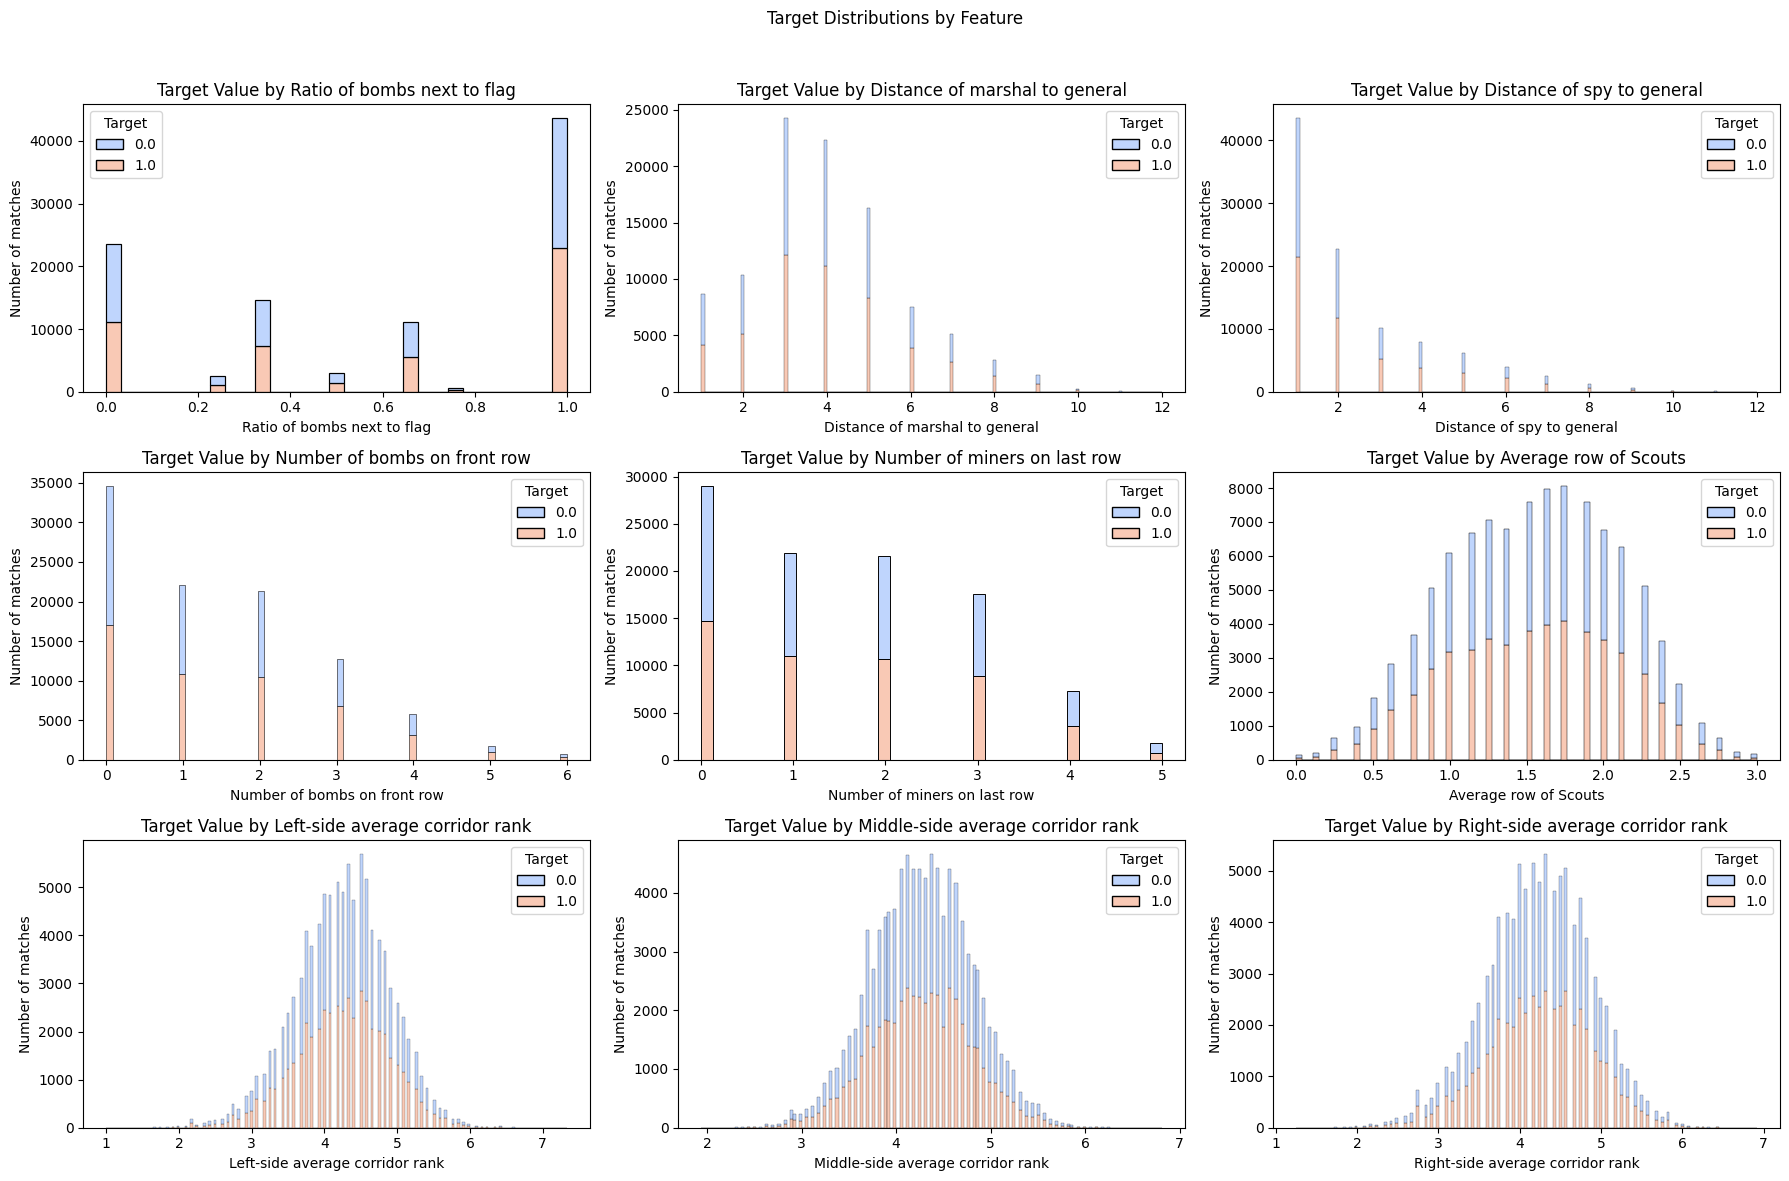

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
fig.suptitle('Target Distributions by Feature')

for i, ax in enumerate(axes.flatten()):
    if i < 9:  # We only have 9 features to plot
        feature_col = df.columns[i]

        # Calculate the mean target value for each value of the feature

        means_by_feature = df.groupby('Target').mean()

        # Plot the mean target value for each value of the feature
        #means_by_feature.plot(ax=ax, marker='o', linestyle='-')
        sns.histplot(data=df, x=feature_col, hue='Target', multiple='stack', ax=ax, palette='coolwarm')
        ax.set_title(f'Target Value by {feature_col}')
        #ax.set_xlim(0,1)
        ax.set_xlabel(feature_col)
        ax.set_ylabel('Number of matches')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Anlysis of strategy ratio fo bombs next to flag

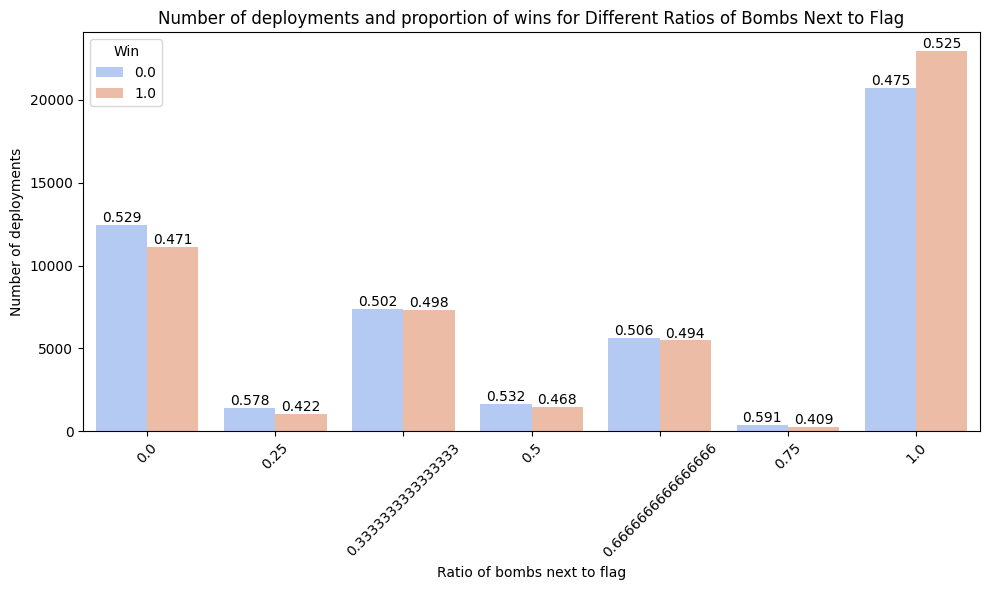

In [ ]:

grouped = df.groupby(['Ratio of bombs next to flag', 'Target']).agg(
    count=('Ratio of bombs next to flag', 'size')
).reset_index()

#get proportions of wins to losses for each ratio
for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=3)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=3)

grouped['proportion'] = list(grouped['proportion'])[::2] + list(grouped['proportion'])[1::2] #makes sure it allignes with the plot


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped, x='Ratio of bombs next to flag', y='count', hue='Target', palette='coolwarm')
plt.title('Proportion of wins(red) and losses(blue) for Ratio of bombs next to flag')
plt.xlabel('Ratio of bombs next to flag')
plt.ylabel('Number of deployments')
plt.xticks(rotation=45)
plt.legend(title='Win')

for p, val in zip(ax.patches, grouped['proportion']):
    ax.annotate(str(val),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()# Ensure all lists have the same length





Checking significance of ratio of bombs next to flag

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=3)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=3)
# Your DataFrame


data = pd.DataFrame(grouped)

# Pivot the DataFrame to create the contingency table
contingency_table = data.pivot(index='Ratio of bombs next to flag', columns='Target', values='count')

# Fill NaN values with 0
contingency_table = contingency_table.fillna(0)

# Perform the Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the results
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(ex)


Chi2 statistic: 282.2112010093016
P-value: 5.28238721906026e-58
Degrees of freedom: 6
Expected frequencies:
[[11795.  11795. ]
 [ 1226.5  1226.5]
 [ 7341.5  7341.5]
 [ 1532.5  1532.5]
 [ 5540.5  5540.5]
 [  298.    298. ]
 [21831.  21831. ]]


Visualize trend lines for ratio of bombs next to flag

Target: 0.0, Polynomial coefficients: [-0.1308628   0.09694443  0.52739483], R-squared: 0.18732199359720306
Target: 1.0, Polynomial coefficients: [ 0.1308628  -0.09694443  0.47260517], R-squared: 0.18732199359720186


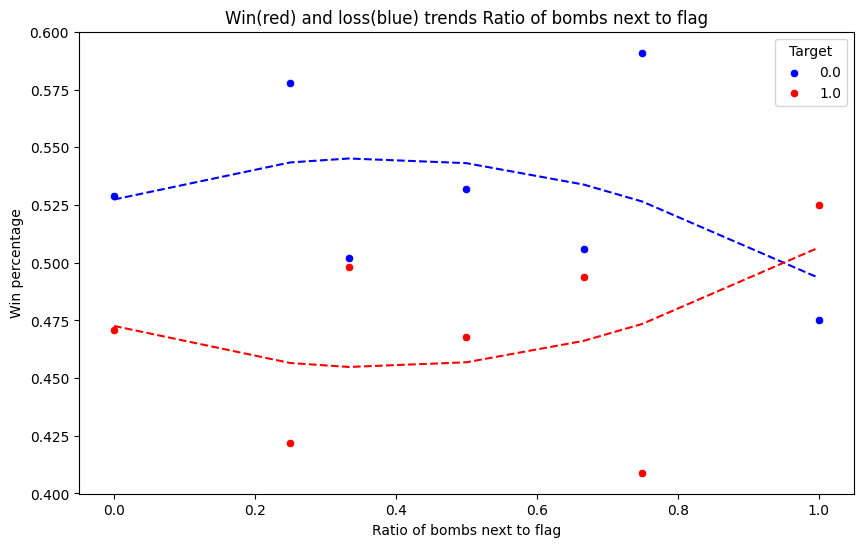

In [ ]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']

# Add trend lines for each category
for i, target in enumerate(grouped['Target'].unique()):
    subset = grouped[grouped['Target'] == target]

    # Plot the data points
    sns.scatterplot(data=subset, x='Ratio of bombs next to flag', y='proportion', ax=ax, color=colors[i], label=target)

    # Polynomial fitting instead of linear regression
    z = np.polyfit(subset['Ratio of bombs next to flag'], subset['proportion'], 2)
    p = np.poly1d(z)
    trendline = p(subset['Ratio of bombs next to flag'])

    # Add the trend line to the plot
    sns.lineplot(x=subset['Ratio of bombs next to flag'], y=trendline, ax=ax, color=colors[i], linestyle='--')
    # Calculate R-squared value for the polynomial fit
    r_squared = np.corrcoef(subset['proportion'], trendline)[0, 1]**2
    print(f"Target: {target}, Polynomial coefficients: {z}, R-squared: {r_squared}")

plt.title("Win(red) and loss(blue) trends Ratio of bombs next to flag")
plt.xlabel("Ratio of bombs next to flag")
plt.ylabel("Proportion")
plt.legend(title='Target')

plt.show()


Anlysis of strategy distance of spy-general

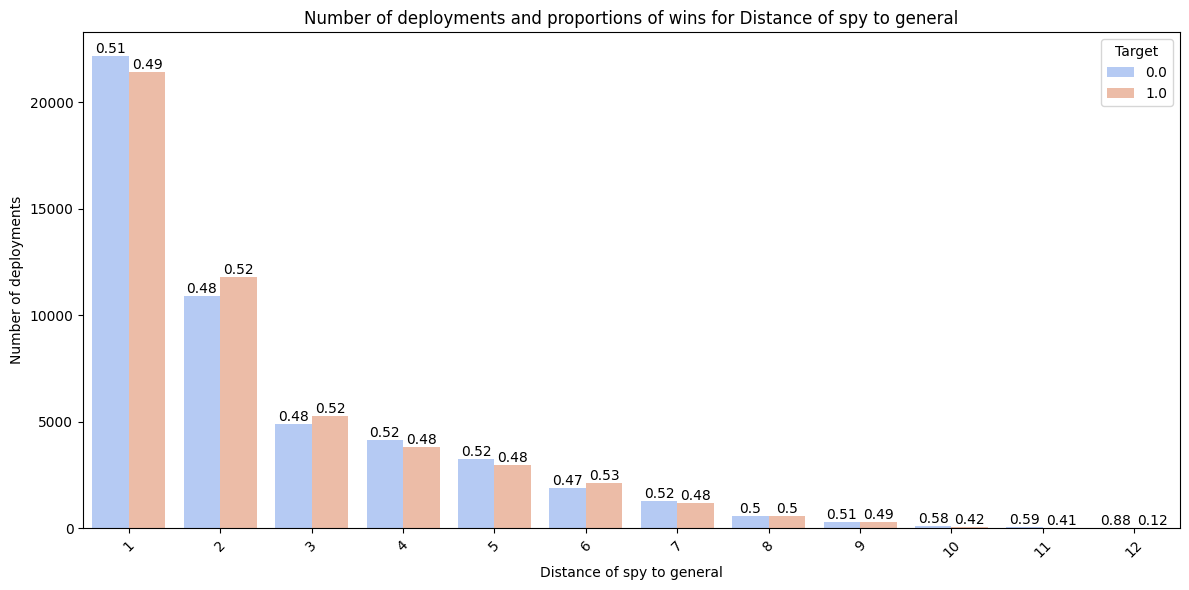

In [ ]:

grouped = df.groupby(['Distance of spy to general', 'Target']).agg(
    count=('Distance of spy to general', 'size')
).reset_index()

#get proportions of wins to losses for each ratio
for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=2)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=2)

grouped['proportion'] = list(grouped['proportion'])[::2] + list(grouped['proportion'])[1::2] #makes sure it allignes with the plot


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grouped, x='Distance of spy to general', y='count', hue='Target', palette='coolwarm')
plt.title('Proportion of wins(red) and losses(blue) for Distance of spy to general')
plt.xlabel('Distance of spy to general')
plt.ylabel('Number of deployments')
plt.xticks(rotation=45)
plt.legend(title='Target')

for p, val in zip(ax.patches, grouped['proportion']):
    ax.annotate(str(val),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()




In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=3)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=3)
# Your DataFrame


data = pd.DataFrame(grouped)

# Pivot the DataFrame to create the contingency table
contingency_table = data.pivot(index='Distance of spy to general', columns='Target', values='count')

# Fill NaN values with 0
contingency_table = contingency_table.fillna(0)

# Perform the Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the results
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(ex)


Chi2 statistic: 110.56856796474489
P-value: 1.4103828751867277e-18
Degrees of freedom: 11
Expected frequencies:
[[2.17890e+04 2.17890e+04]
 [1.13435e+04 1.13435e+04]
 [5.10150e+03 5.10150e+03]
 [3.96900e+03 3.96900e+03]
 [3.11550e+03 3.11550e+03]
 [2.00350e+03 2.00350e+03]
 [1.25450e+03 1.25450e+03]
 [5.76500e+02 5.76500e+02]
 [2.84500e+02 2.84500e+02]
 [8.90000e+01 8.90000e+01]
 [3.45000e+01 3.45000e+01]
 [4.00000e+00 4.00000e+00]]


Visualize trend lines for distance spy-general

Target: 0.0, Polynomial coefficients: [ 0.00555145 -0.05232268  0.58622727], R-squared: 0.7369086053090297
Target: 1.0, Polynomial coefficients: [-0.00555145  0.05232268  0.41377273], R-squared: 0.7369086053090299


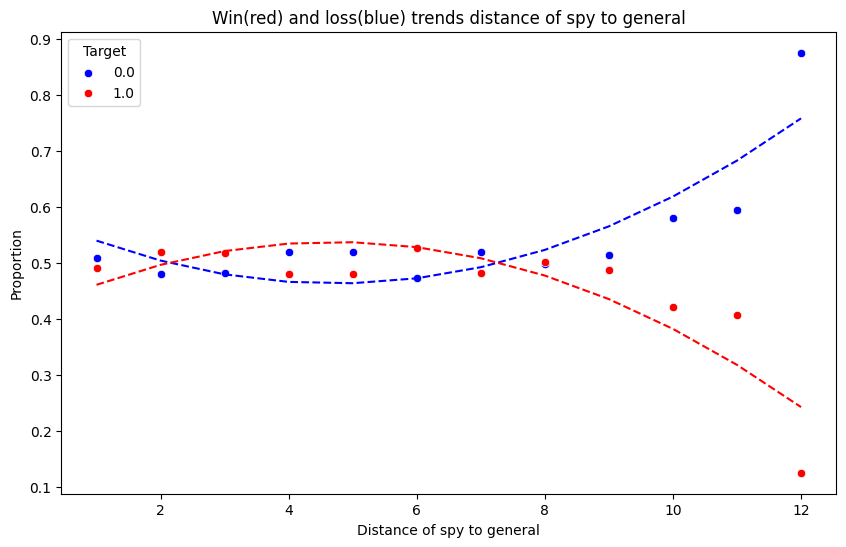

In [ ]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']

# Add trend lines for each category
for i, target in enumerate(grouped['Target'].unique()):
    subset = grouped[grouped['Target'] == target]

    # Plot the data points
    sns.scatterplot(data=subset, x='Distance of spy to general', y='proportion', ax=ax, color=colors[i], label=target)

    # Polynomial fitting instead of linear regression
    z = np.polyfit(subset['Distance of spy to general'], subset['proportion'], 2)
    p = np.poly1d(z)
    trendline = p(subset['Distance of spy to general'])

    # Add the trend line to the plot
    sns.lineplot(x=subset['Distance of spy to general'], y=trendline, ax=ax, color=colors[i], linestyle='--')
    # Calculate R-squared value for the polynomial fit
    r_squared = np.corrcoef(subset['proportion'], trendline)[0, 1]**2
    print(f"Target: {target}, Polynomial coefficients: {z}, R-squared: {r_squared}")

plt.title("Win(red) and loss(blue) trends distance of spy to general")
plt.xlabel("Distance of spy to general")
plt.ylabel("Proportion")
plt.legend(title='Target')

plt.show()


Anlysis of strategy distance of marshal-general

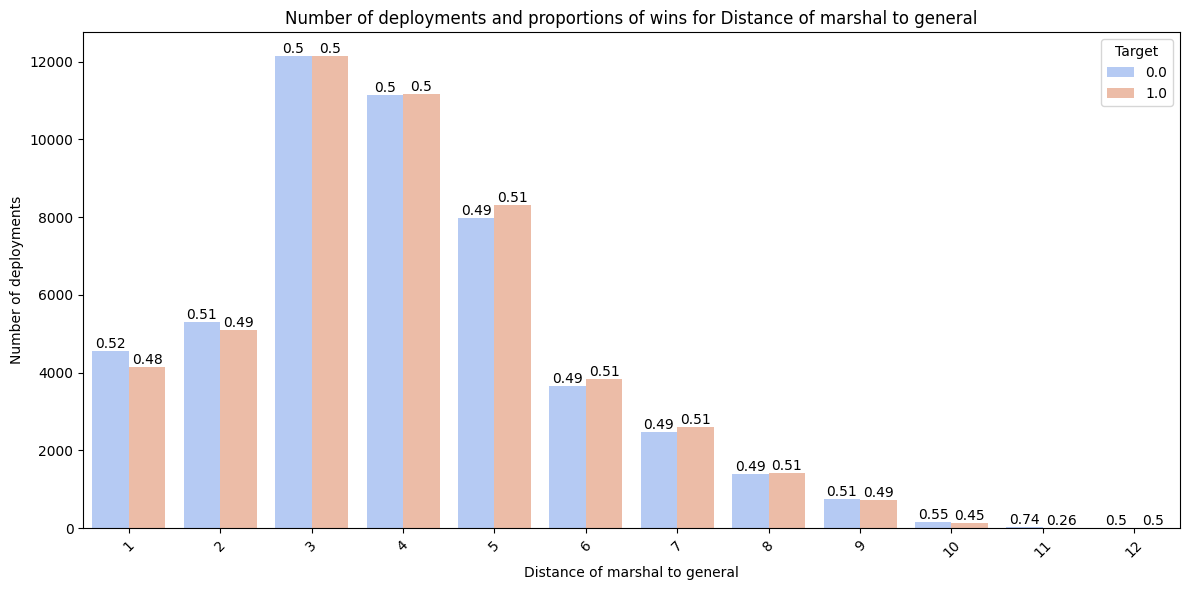

In [ ]:

grouped = df.groupby(['Distance of marshal to general', 'Target']).agg(
    count=('Distance of marshal to general', 'size')
).reset_index()

#get proportions of wins to losses for each ratio
for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=2)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=2)

grouped['proportion'] = list(grouped['proportion'])[::2] + list(grouped['proportion'])[1::2]


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grouped, x='Distance of marshal to general', y='count', hue='Target', palette='coolwarm')
plt.title('Proportion of wins(red) and losses(blue) for Distance of marshal to general')
plt.xlabel('Distance of marshal to general')
plt.ylabel('Number of deployments')
plt.xticks(rotation=45)
plt.legend(title='Target')

for p, val in zip(ax.patches, grouped['proportion']):
    ax.annotate(str(val),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')


plt.tight_layout()
plt.show()




In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, linregress

for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=3)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=3)
# Your DataFrame


data = pd.DataFrame(grouped)

# Pivot the DataFrame to create the contingency table
contingency_table = data.pivot(index='Distance of marshal to general', columns='Target', values='count')

# Fill NaN values with 0
contingency_table = contingency_table.fillna(0)

# Perform the Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the results
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(ex)


Chi2 statistic: 47.44257378848007
P-value: 1.7943110654105238e-06
Degrees of freedom: 11
Expected frequencies:
[[4.35100e+03 4.35100e+03]
 [5.19400e+03 5.19400e+03]
 [1.21395e+04 1.21395e+04]
 [1.11485e+04 1.11485e+04]
 [8.13950e+03 8.13950e+03]
 [3.75350e+03 3.75350e+03]
 [2.53950e+03 2.53950e+03]
 [1.40450e+03 1.40450e+03]
 [7.36500e+02 7.36500e+02]
 [1.40000e+02 1.40000e+02]
 [1.55000e+01 1.55000e+01]
 [3.00000e+00 3.00000e+00]]


Visualize trend for distance marshal-general

Target: 0.0, Polynomial coefficients: [ 0.0022018  -0.02067932  0.53981818], R-squared: 0.28006022173994216
Target: 1.0, Polynomial coefficients: [-0.0022018   0.02067932  0.46018182], R-squared: 0.28006022173994227


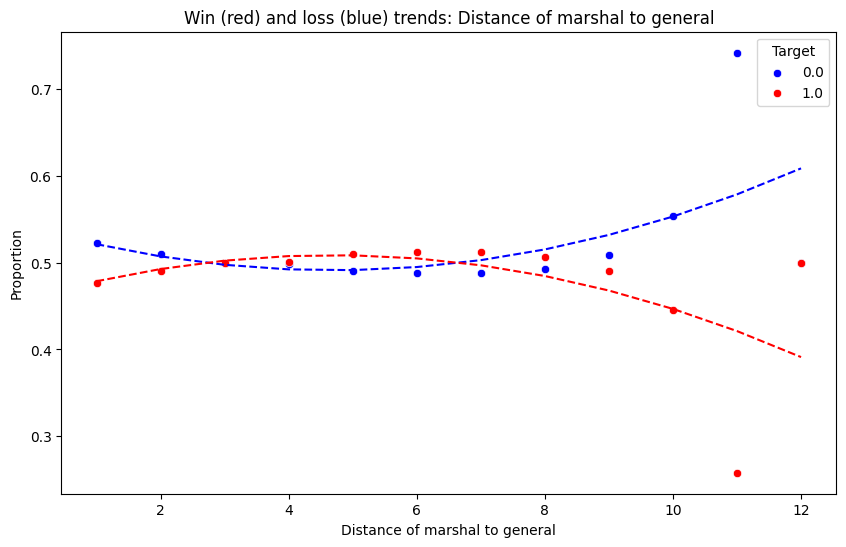

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np


# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']

# Add trend lines for each category
for i, target in enumerate(grouped['Target'].unique()):
    subset = grouped[grouped['Target'] == target]

    # Plot the data points
    sns.scatterplot(data=subset, x='Distance of marshal to general', y='proportion', ax=ax, color=colors[i], label=target)

    # Polynomial fitting instead of linear regression
    z = np.polyfit(subset['Distance of marshal to general'], subset['proportion'], 2)
    p = np.poly1d(z)
    trendline = p(subset['Distance of marshal to general'])

    # Add the trend line to the plot
    sns.lineplot(x=subset['Distance of marshal to general'], y=trendline, ax=ax, color=colors[i], linestyle='--')
    # Calculate R-squared value for the polynomial fit
    r_squared = np.corrcoef(subset['proportion'], trendline)[0, 1]**2
    print(f"Target: {target}, Polynomial coefficients: {z}, R-squared: {r_squared}")

plt.title("Win (red) and loss (blue) trends: Distance of marshal to general")
plt.xlabel("Distance of marshal to general")
plt.ylabel("Proportion")
plt.legend(title='Target')

plt.show()


Anlysis of strategy number of bombs on front row

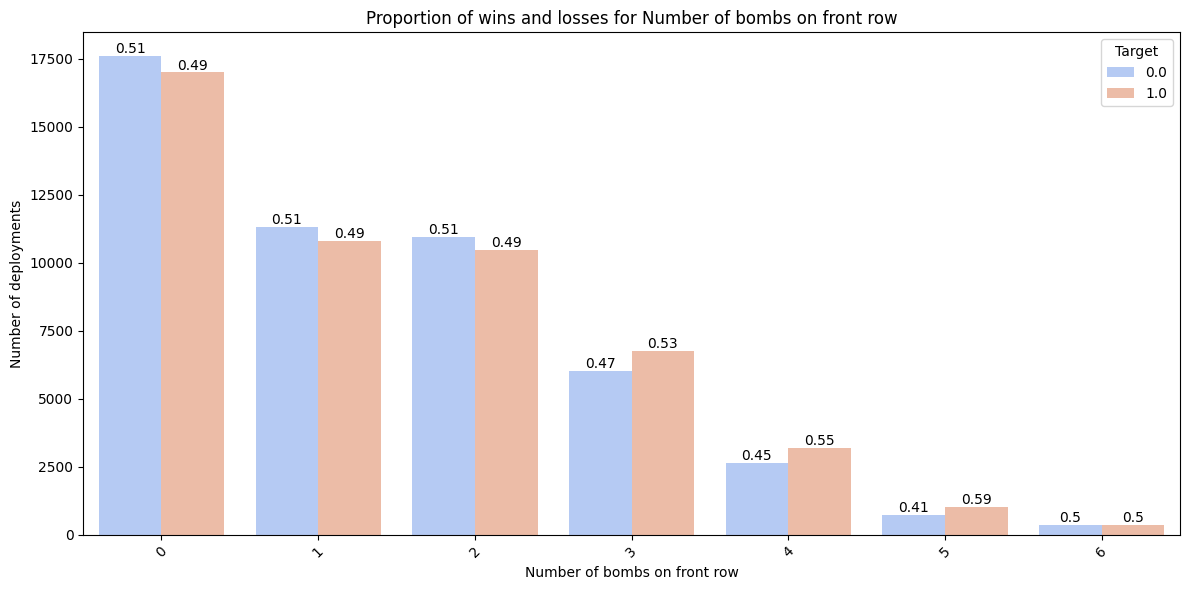

In [ ]:

grouped = df.groupby(['Number of bombs on front row', 'Target']).agg(
    count=('Number of bombs on front row', 'size')
).reset_index()

#get proportions of wins to losses for each ratio
for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=2)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=2)

grouped['proportion'] = list(grouped['proportion'])[::2] + list(grouped['proportion'])[1::2]


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grouped, x='Number of bombs on front row', y='count', hue='Target', palette='coolwarm')
plt.title('Proportion of wins(red) and losses(blue) for Number of bombs on front row')
plt.xlabel('Number of bombs on front row')
plt.ylabel('Number of deployments')
plt.xticks(rotation=45)
plt.legend(title='Target')

for p, val in zip(ax.patches, grouped['proportion']):
    ax.annotate(str(val),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')


plt.tight_layout()
plt.show()




In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, linregress

for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=3)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=3)
# Your DataFrame


data = pd.DataFrame(grouped)

# Pivot the DataFrame to create the contingency table
contingency_table = data.pivot(index='Number of bombs on front row', columns='Target', values='count')

# Fill NaN values with 0
contingency_table = contingency_table.fillna(0)

# Perform the Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the results
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(ex)


Chi2 statistic: 184.11819565772797
P-value: 4.5266782931697024e-37
Degrees of freedom: 6
Expected frequencies:
[[17299.  17299. ]
 [11073.  11073. ]
 [10694.  10694. ]
 [ 6379.5  6379.5]
 [ 2902.5  2902.5]
 [  865.    865. ]
 [  352.    352. ]]


Visualize trends for number of bombs on front row

Target: 0.0, Polynomial coefficients: [ 0.00328571 -0.02985714  0.528     ], R-squared: 0.43103336151394966
Target: 1.0, Polynomial coefficients: [-0.00328571  0.02985714  0.472     ], R-squared: 0.4310333615139495


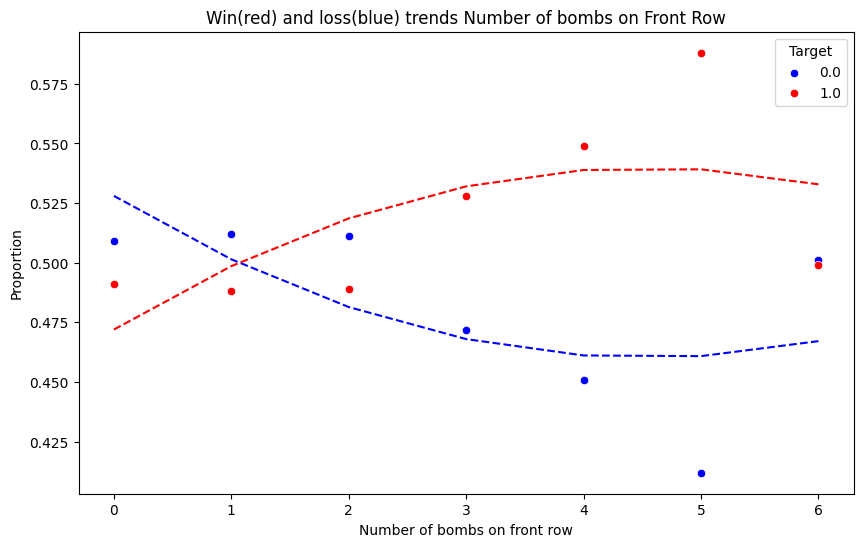

In [ ]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']

# Add trend lines for each category
for i, target in enumerate(grouped['Target'].unique()):
    subset = grouped[grouped['Target'] == target]

    # Plot the data points
    sns.scatterplot(data=subset, x='Number of bombs on front row', y='proportion', ax=ax, color=colors[i], label=target)

    # Polynomial fitting instead of linear regression
    z = np.polyfit(subset['Number of bombs on front row'], subset['proportion'], 2)
    p = np.poly1d(z)
    trendline = p(subset['Number of bombs on front row'])

    # Add the trend line to the plot
    sns.lineplot(x=subset['Number of bombs on front row'], y=trendline, ax=ax, color=colors[i], linestyle='--')
    # Calculate R-squared value for the polynomial fit
    r_squared = np.corrcoef(subset['proportion'], trendline)[0, 1]**2
    print(f"Target: {target}, Polynomial coefficients: {z}, R-squared: {r_squared}")

plt.title("Win(red) and loss(blue) trends Number of bombs on Front Row")
plt.xlabel("Number of bombs on front row")
plt.ylabel("Proportion")
plt.legend(title='Target')

plt.show()


Analysis of strategy Number of miners on last row

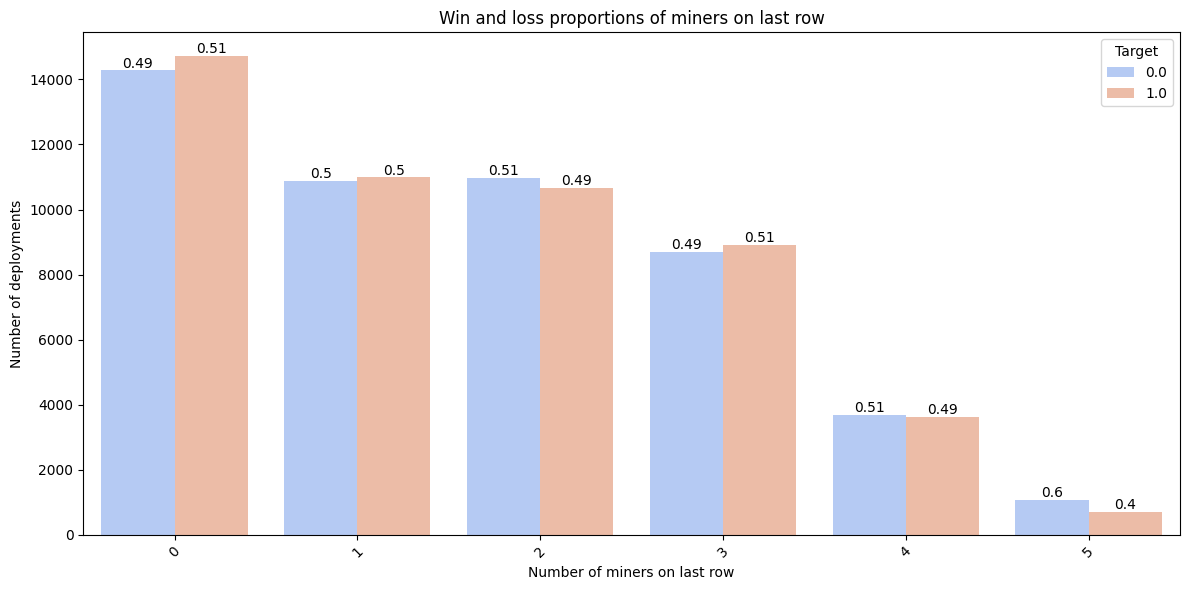

In [ ]:

grouped = df.groupby(['Number of miners on last row', 'Target']).agg(
    count=('Number of miners on last row', 'size')
).reset_index()

#get proportions of wins to losses for each ratio
for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=2)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=2)

grouped['proportion'] = list(grouped['proportion'])[::2] + list(grouped['proportion'])[1::2]


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grouped, x='Number of miners on last row', y='count', hue='Target', palette='coolwarm')
plt.title('Win(red) and loss(blue) proportions of miners on last row')
plt.xlabel('Number of miners on last row')
plt.ylabel('Number of deployments')
plt.xticks(rotation=45)
plt.legend(title='Target')

for p, val in zip(ax.patches, grouped['proportion']):
    ax.annotate(str(val),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')


plt.tight_layout()
plt.show()




In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, linregress

for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=3)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=3)
# Your DataFrame


data = pd.DataFrame(grouped)

# Pivot the DataFrame to create the contingency table
contingency_table = data.pivot(index='Number of miners on last row', columns='Target', values='count')

# Fill NaN values with 0
contingency_table = contingency_table.fillna(0)

# Perform the Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the results
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(ex)


Chi2 statistic: 83.59158149830952
P-value: 1.4854989231558566e-16
Degrees of freedom: 5
Expected frequencies:
[[14496.5 14496.5]
 [10932.  10932. ]
 [10803.5 10803.5]
 [ 8802.   8802. ]
 [ 3650.5  3650.5]
 [  880.5   880.5]]


Visualize trends for number of miners on last row

Target: 0.0, Polynomial coefficients: [ 0.00792857 -0.0241      0.50357143], R-squared: 0.7797099484955275
Target: 1.0, Polynomial coefficients: [-0.00792857  0.0241      0.49642857], R-squared: 0.7797099484955273


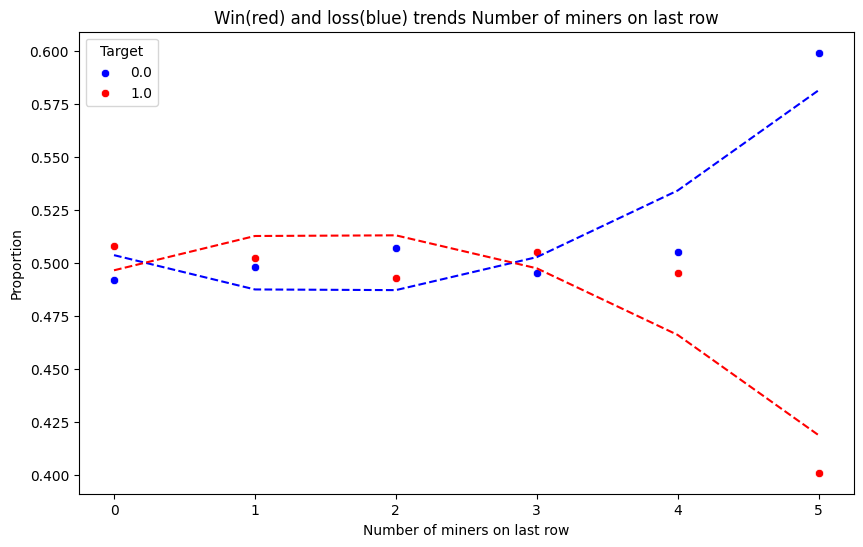

In [ ]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']

# Add trend lines for each category
for i, target in enumerate(grouped['Target'].unique()):
    subset = grouped[grouped['Target'] == target]

    # Plot the data points
    sns.scatterplot(data=subset, x='Number of miners on last row', y='proportion', ax=ax, color=colors[i], label=target)

    # Polynomial fitting instead of linear regression
    z = np.polyfit(subset['Number of miners on last row'], subset['proportion'], 2)
    p = np.poly1d(z)
    trendline = p(subset['Number of miners on last row'])

    # Add the trend line to the plot
    sns.lineplot(x=subset['Number of miners on last row'], y=trendline, ax=ax, color=colors[i], linestyle='--')
    # Calculate R-squared value for the polynomial fit
    r_squared = np.corrcoef(subset['proportion'], trendline)[0, 1]**2
    print(f"Target: {target}, Polynomial coefficients: {z}, R-squared: {r_squared}")

plt.title("Win(red) and loss(blue) trends Number of miners on last row")
plt.xlabel("Number of miners on last row")
plt.ylabel("Proportion")
plt.legend(title='Target')

plt.show()


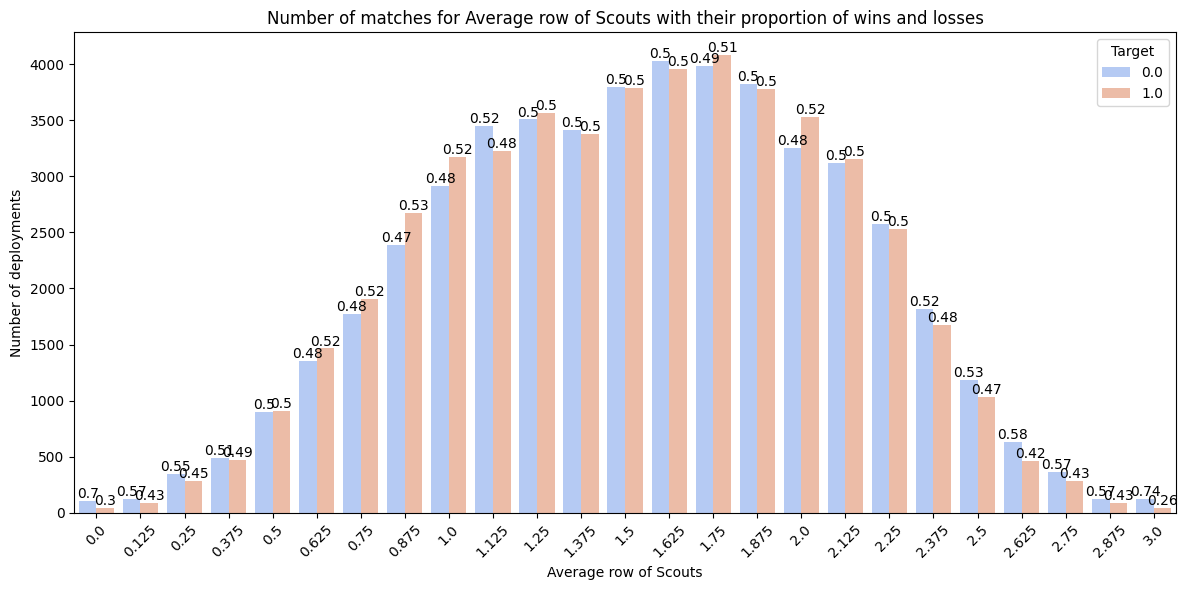

In [ ]:
grouped = df.groupby(['Average row of Scouts', 'Target']).agg(
    count=('Average row of Scouts', 'size')
).reset_index()

#get proportions of wins to losses for each ratio
for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=2)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=2)

grouped['proportion'] = list(grouped['proportion'])[::2] + list(grouped['proportion'])[1::2]


plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grouped, x='Average row of Scouts', y='count', hue='Target', palette='coolwarm')
plt.title('Number of matches for Average row of Scouts with their proportion of wins(red) and losses(blue)')
plt.xlabel('Average row of Scouts')
plt.ylabel('Number of deployments')
plt.xticks(rotation=45)
plt.legend(title='Target')

for p, val in zip(ax.patches, grouped['proportion']):
    ax.annotate(str(val),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')


plt.tight_layout()
plt.show()




In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, linregress

for i in range(0, len(grouped), 2):
    count1 = grouped.iloc[i]['count']
    count2 = grouped.iloc[i + 1]['count']
    total_count = count1 + count2
    ratio1 = count1 / total_count
    ratio2 = count2 / total_count
    grouped.at[i, 'proportion'] = round(ratio1,ndigits=3)
    grouped.at[i + 1, 'proportion'] = round(ratio2,ndigits=3)
# Your DataFrame


data = pd.DataFrame(grouped)

# Pivot the DataFrame to create the contingency table
contingency_table = data.pivot(index='Average row of Scouts', columns='Target', values='count')

# Fill NaN values with 0
contingency_table = contingency_table.fillna(0)

# Perform the Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the results
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(ex)


Chi2 statistic: 187.10067995123228
P-value: 3.203253939763684e-27
Degrees of freedom: 24
Expected frequencies:
[[  74.    74. ]
 [ 106.   106. ]
 [ 315.5  315.5]
 [ 482.5  482.5]
 [ 904.5  904.5]
 [1409.  1409. ]
 [1837.  1837. ]
 [2530.5 2530.5]
 [3042.5 3042.5]
 [3335.5 3335.5]
 [3534.  3534. ]
 [3396.5 3396.5]
 [3790.5 3790.5]
 [3990.  3990. ]
 [4029.5 4029.5]
 [3799.5 3799.5]
 [3389.  3389. ]
 [3136.  3136. ]
 [2552.5 2552.5]
 [1743.  1743. ]
 [1111.  1111. ]
 [ 546.   546. ]
 [ 322.5  322.5]
 [ 106.5  106.5]
 [  81.5   81.5]]


Visualize trends for Average row of scouts

Target: 0.0, Polynomial coefficients: [ 0.07184601 -0.2025534   0.61376171], R-squared: 0.6979027957670322
Target: 1.0, Polynomial coefficients: [-0.07184601  0.2025534   0.38623829], R-squared: 0.6979027957670327


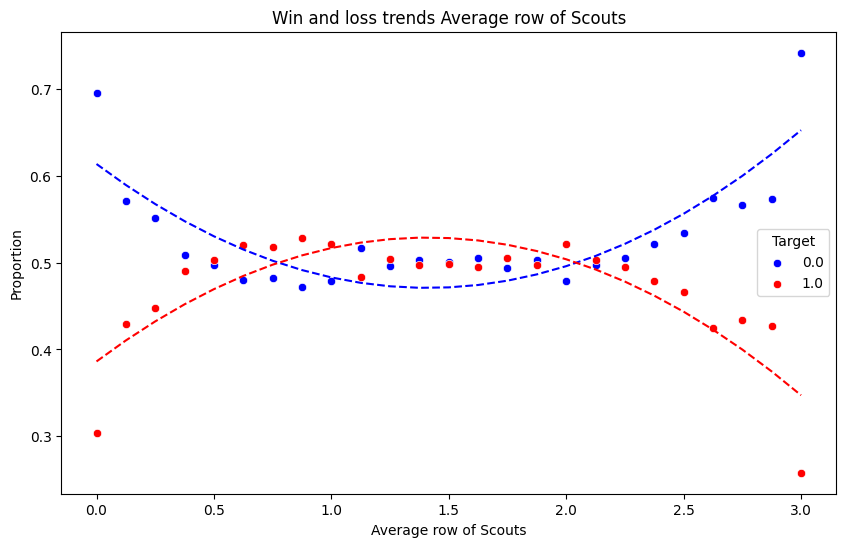

In [ ]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']

# Add trend lines for each category
for i, target in enumerate(grouped['Target'].unique()):
    subset = grouped[grouped['Target'] == target]

    # Plot the data points
    sns.scatterplot(data=subset, x='Average row of Scouts', y='proportion', ax=ax, color=colors[i], label=target)

    # Polynomial fitting instead of linear regression
    z = np.polyfit(subset['Average row of Scouts'], subset['proportion'], 2)
    p = np.poly1d(z)
    trendline = p(subset['Average row of Scouts'])

    # Add the trend line to the plot
    sns.lineplot(x=subset['Average row of Scouts'], y=trendline, ax=ax, color=colors[i], linestyle='--')
    # Calculate R-squared value for the polynomial fit
    r_squared = np.corrcoef(subset['proportion'], trendline)[0, 1]**2
    print(f"Target: {target}, Polynomial coefficients: {z}, R-squared: {r_squared}")

plt.title("Win(red) and loss(blue) trends Average row of Scouts")
plt.xlabel("Average row of Scouts")
plt.ylabel("Proportion")
plt.legend(title='Target')

plt.show()


Win percentage of optimal deployment according to the analysis of strategies

In [ ]:
scoutrow = 0
minersonlastrow = 0
numbombsfront = 6
distancemasrshalgeneral = 1
distancespygeneral = 1
ratiobombsflag = 1

#Filter the DataFrame based on conditions
optimal_strat_df = df[
    #(df['Average row of Scouts'] == scoutrow) &
    (df['Number of miners on last row'] == minersonlastrow) &
    #(df['Number of bombs on front row'] == numbombsfront) |
    #(df['Distance of marshal to general'] == distancemasrshalgeneral) &
    #(df['Distance of spy to general'] == distancespygeneral) &
    (df['Ratio of bombs next to flag'] == ratiobombsflag)
]


In [ ]:
optimal_strat_df['Target'].describe()

count    13714.000000
mean         0.546376
std          0.497863
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Target, dtype: float64

In [ ]:
df

,Ratio of bombs next to flag,Distance of marshal to general,Distance of spy to general,Number of bombs on front row,Number of miners on last row,Average row of Scouts,Left-side average corridor rank,Middle-side average corridor rank,Right-side average corridor rank,Target
0,1.000000,3,1,0,4,2.000,4.416667,3.8750,4.583333,0.0
1,0.333333,6,1,0,4,2.125,3.500000,4.3125,4.916667,0.0
2,1.000000,3,1,0,4,2.375,4.500000,3.8750,4.500000,0.0
3,1.000000,4,2,1,5,1.625,3.833333,4.5000,4.333333,0.0
4,1.000000,3,1,0,4,2.375,4.500000,3.8750,4.500000,1.0
...,...,...,...,...,...,...,...,...,...,...
99125,1.000000,6,6,0,3,2.125,5.000000,3.8750,4.000000,1.0
99126,0.000000,4,5,2,4,1.875,4.750000,3.6875,4.500000,0.0
99127,0.333333,6,1,0,3,2.375,4.250000,4.5625,3.833333,1.0
99128,1.000000,5,4,0,3,1.750,4.166667,4.1875,4.416667,0.0


Saving the new data frame with the added strategies to the positions array

We exclude the added strategies that were of personal interest since they overal seem insignificant

In [ ]:
# Reshape array2 to have the same number of dimensions as array1
df_array = np.array(df[["Ratio of bombs next to flag","Distance of marshal to general", "Distance of spy to general","Number of bombs on front row","Number of miners on last row" ]])


df_array = np.expand_dims(df_array, axis=1)  # Shape becomes (99130, 1, 10)
df_array = np.repeat(df_array, 40, axis=1)   # Shape becomes (99130, 40, 10)
# Concatenate along the third dimension
result_array = np.concatenate((positions, df_array), axis=2)

print(result_array.shape)  # Should print (99130, 40, 17)

**This is important!**

We Save this file and add it to the files folder, this will be used for training the neural networks

In [ ]:
#!!! please download this file and add it to the files folder
joblib.dump(result_array, "X_encoded_strategies_and_positions.txt")


Finding identitical deployments

In [ ]:
import numpy as np


# Flatten each array and convert to tuple
flattened_arrays = [tuple(arr.flatten()) for arr in positions]

# Dictionary to store occurrences of each flattened array
array_dict = {}

for idx, arr in enumerate(flattened_arrays):
    if arr in array_dict:
        array_dict[arr].append(idx)
    else:
        array_dict[arr] = [idx]

# Find and print identical arrays
identical_arrays = {k: v for k, v in array_dict.items() if len(v) > 1}
value_list = []
#print("Identical arrays found at indices:")
for key, value in identical_arrays.items():
    #print(f"Indices: {value}")
    value_list.append(value)

In [ ]:
occurences = {}
total_items = 0
for sublist in value_list:
    total_items += len(sublist)
    occurences[str(sublist)] = len(sublist)

In [ ]:
from collections import Counter

# Your array

# Count the occurrences of each number
counter = Counter(occurences.values())

# Separate the keys and values for plotting
numbers = list(counter.keys())
frequencies = list(counter.values())

# Plot the histogram
plt.figure(figsize=(15, 7))
plt.bar(numbers, frequencies, color='skyblue')
plt.xlabel('Amount of identical deployments')
plt.ylabel('Number of unique deployments')
plt.title('How often deployments had an identical deployment and how many')
plt.grid(axis='y')
plt.show()


In [ ]:

max_value = max(occurences.values())
for key, value in occurences.items():
    if value == max_value:
        print(f'Key with the max value: {key}')
        break


import ast


actual_list = ast.literal_eval(key)
actual_list

print("1 deployment occured times:")
max(occurences.values())

win_rate = np.mean(np.array(winners_new)[actual_list])

print("deployment has a 0.58% win rate")

In [ ]:
df.iloc[41034], positions[41034]

In [ ]:
print("1 deployment occured times:")
max(occurences.values())

In [ ]:
sorted_deployments = sorted(occurences.items(), key=lambda item: item[1], reverse=True)[:20]

# Prepare a list to store the results
top_deployments_win_rates = []

# Calculate win rate for each of the top deployments
for deployment, count in sorted_deployments:
    actual_list = ast.literal_eval(deployment)
    win_rate = np.mean([winners_new[i] for i in actual_list])
    top_deployments_win_rates.append((actual_list, count, win_rate))

# Print the results
rates = []
deployment_list = []
for deployment, count, win_rate in top_deployments_win_rates:
    print(f"Deployment: {deployment}, Count: {count}, Win Rate: {win_rate:.2%}")
    rates.append(win_rate)
    deployment_list.append(deployment)


Creating Optimal and negative deployments according to strategy's

we use the files 81904 and above since these are GSN files and these can be opened in the strados interface

Please move on to Position_effects_on_model_predictions.ipynb